In [23]:
import pandas as pd
# Datasource: https://www.kaggle.com/berkerisen/wind-turbine-scada-dataset
raw_data = pd.read_csv("D:/Birkbeck/Final Project/Datasets/SHORTLIST/Wind Turbine Scada Dataset/T1.csv/T1.csv")
raw_data.columns

Index(['Date/Time', 'LV ActivePower (kW)', 'Wind Speed (m/s)',
       'Theoretical_Power_Curve (KWh)', 'Wind Direction (°)'],
      dtype='object')

In [24]:
# Convert Date/Time into datetime object
raw_data['Date/Time'] = pd.to_datetime(raw_data['Date/Time'])
# Drop not needed columns
raw_data = raw_data[['Date/Time','LV ActivePower (kW)','Wind Speed (m/s)','Wind Direction (°)']]
# Convert kW into MW
raw_data['LV ActivePower (MW)'] = raw_data['LV ActivePower (kW)']/1000
raw_data = raw_data[['Date/Time','LV ActivePower (MW)','Wind Speed (m/s)','Wind Direction (°)']]

### Pre-processing

In [25]:
import pywt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer 
import numpy as np
import matplotlib.pyplot as plt

In [26]:
"""Split data into train, validation, and test sets"""
# Train dataset first 9 months + reset index
train = raw_data[raw_data['Date/Time'] < '2018-10-01']
train = train.reset_index(drop=True)
# validation dataset 10th month + reset index
valid = raw_data[(raw_data['Date/Time'] < '2018-11-01')&
                (raw_data['Date/Time']>= '2018-10-01')]
valid = valid.reset_index(drop=True)
# test dataset final 2 months + reset index
test = raw_data[raw_data['Date/Time'] >= '2018-11-01']
test = test.reset_index(drop=True)

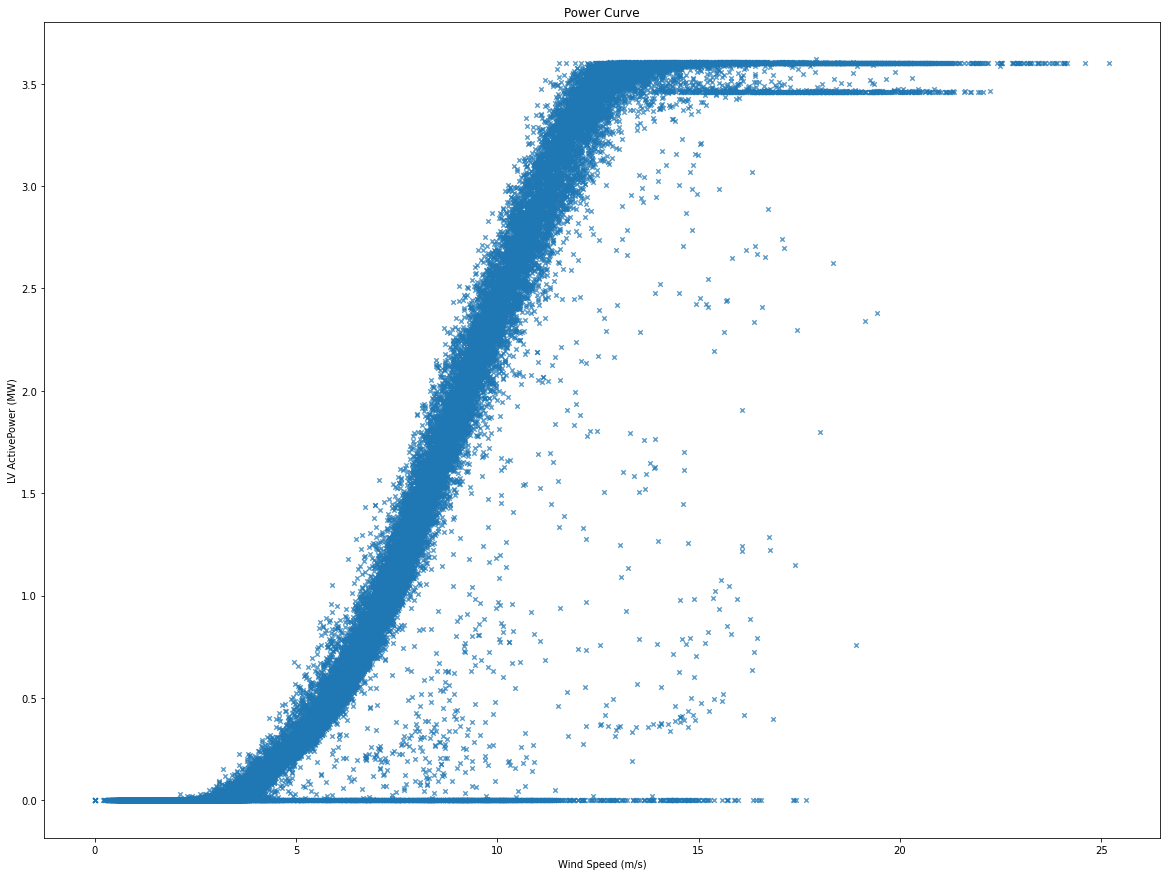

In [27]:
# Plot wind speed vs Active Power
train.plot(kind='scatter',x='Wind Speed (m/s)',y='LV ActivePower (MW)',
           alpha=0.7,title='Power Curve',figsize=(20,15),marker='x')
plt.show()

In [49]:
"""Identify outliers from training data"""
from sklearn import mixture

X = train[['Wind Speed (m/s)','LV ActivePower (MW)']]

gmm = mixture.GaussianMixture(
    n_components=10, covariance_type="full", max_iter=100
).fit(X)
res = gmm.predict(X)
X['res']=res

X1 = X[X['res'] == 0]
X2 = X[X['res'] == 1]
X3 = X[X['res'] == 2]
X4 = X[X['res'] == 3]
X5 = X[X['res'] == 4]
X6 = X[X['res'] == 5]
X7 = X[X['res'] == 6]
X8 = X[X['res'] == 7]
X9 = X[X['res'] == 8]
X10 = X[X['res'] == 9]

<ipython-input-49-3ad1f137c4af>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['res']=res


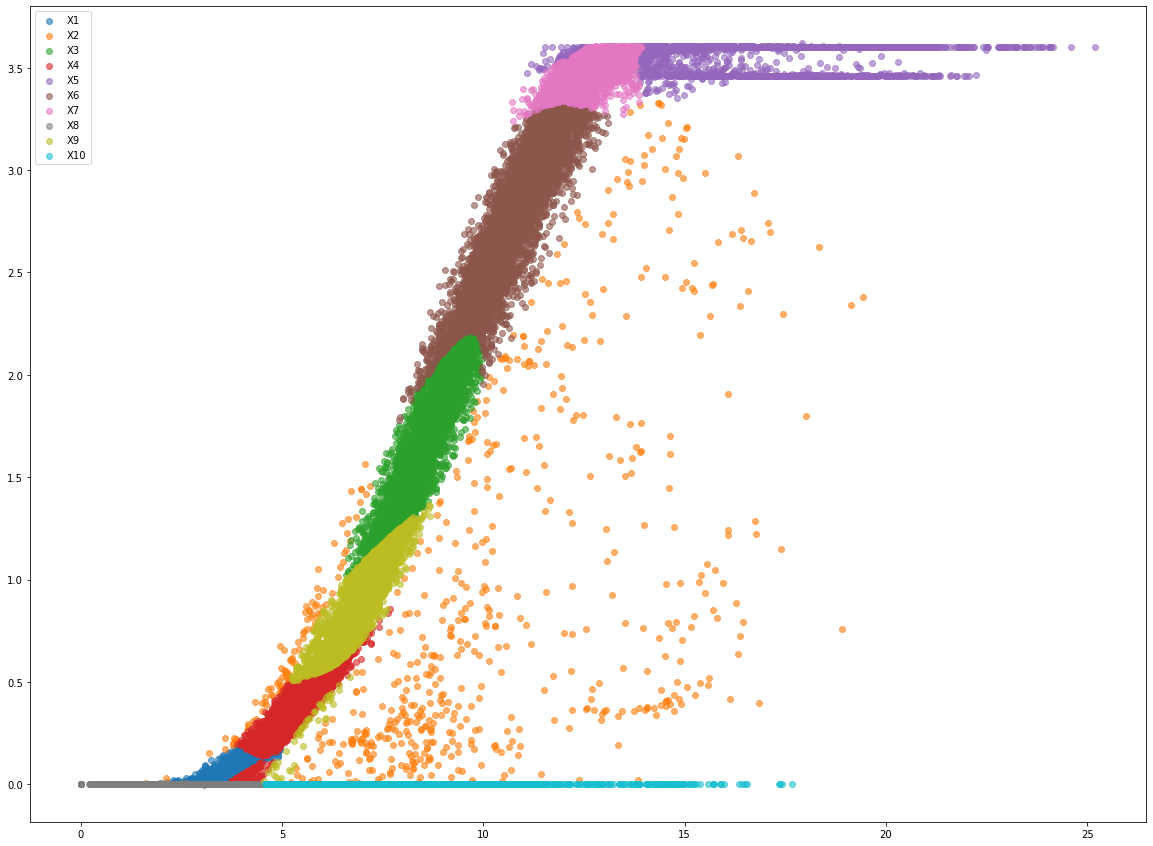

In [54]:
"""Show outlier groups"""
plt.figure(figsize=(20,15))
plt.scatter(X1['Wind Speed (m/s)'],X1['LV ActivePower (MW)'],c='#1f77b4',label='X1',alpha=0.6)
plt.scatter(X2['Wind Speed (m/s)'],X2['LV ActivePower (MW)'],c='#ff7f0e',label='X2',alpha=0.6)
plt.scatter(X3['Wind Speed (m/s)'],X3['LV ActivePower (MW)'],c='#2ca02c',label='X3',alpha=0.6)
plt.scatter(X4['Wind Speed (m/s)'],X4['LV ActivePower (MW)'],c='#d62728',label='X4',alpha=0.6)
plt.scatter(X5['Wind Speed (m/s)'],X5['LV ActivePower (MW)'],c='#9467bd',label='X5',alpha=0.6)
plt.scatter(X6['Wind Speed (m/s)'],X6['LV ActivePower (MW)'],c='#8c564b',label='X6',alpha=0.6)
plt.scatter(X7['Wind Speed (m/s)'],X7['LV ActivePower (MW)'],c='#e377c2',label='X7',alpha=0.6)
plt.scatter(X8['Wind Speed (m/s)'],X8['LV ActivePower (MW)'],c='#7f7f7f',label='X8',alpha=0.6)
plt.scatter(X9['Wind Speed (m/s)'],X9['LV ActivePower (MW)'],c='#bcbd22',label='X9',alpha=0.6)
plt.scatter(X10['Wind Speed (m/s)'],X10['LV ActivePower (MW)'],c='#17becf',label='X10',alpha=0.6)
plt.legend()
plt.show()

In [52]:
"""Remove outliers from training data"""
train['outlier class'] = X['res']
train_f = train[(train['outlier class'] != 9) & (train['outlier class'] != 1)]

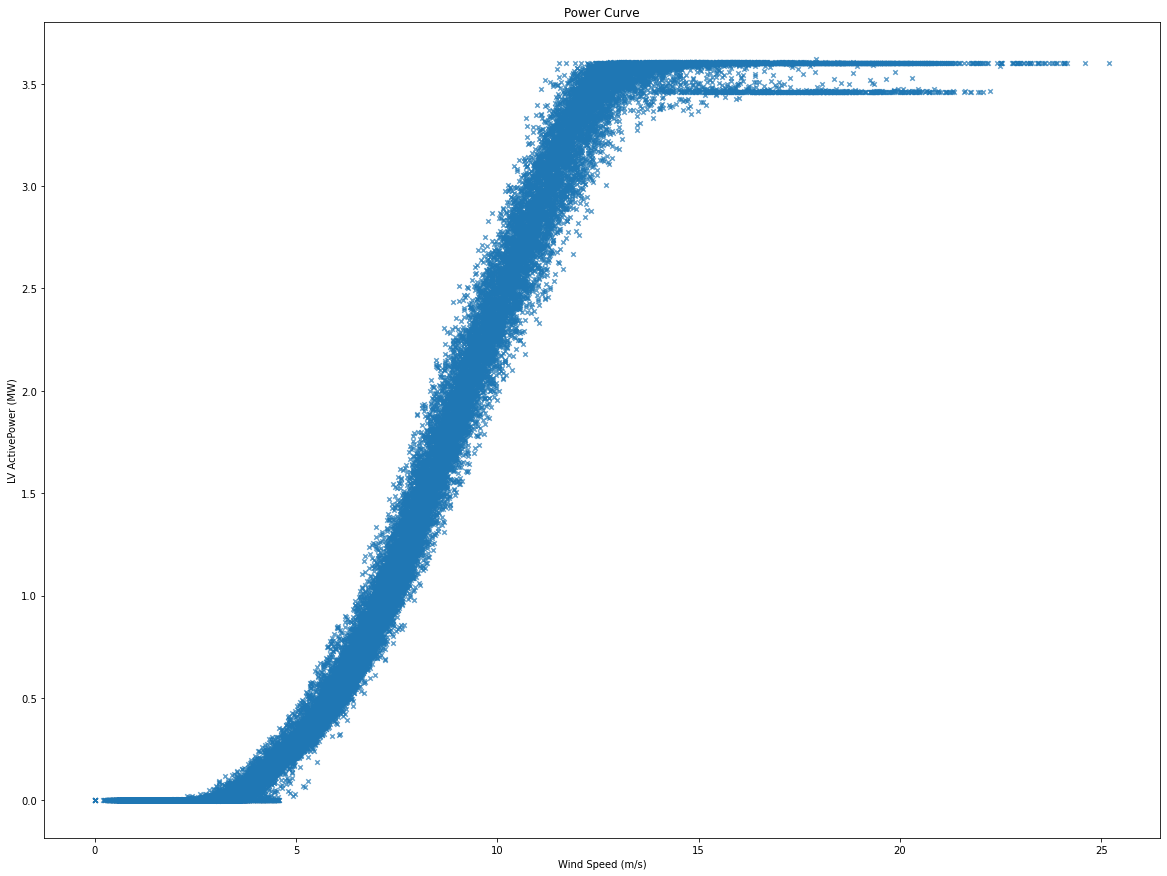

In [53]:
"""Plot wind speed vs Active Power"""
train_f.plot(kind='scatter',x='Wind Speed (m/s)',y='LV ActivePower (MW)',
           alpha=0.7,title='Power Curve',figsize=(20,15),marker='x')
plt.show()

In [168]:
from sklearn.model_selection import cross_val_score
import tensorflow as tf
from tensorflow import keras
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
"""GridSearchCV with an RBF SVM"""
np.random.seed(75)
train_data_prep = train_f[['Wind Speed (m/s)',
                         'LV ActivePower (MW)']][:10000].sort_values(
    by=['Wind Speed (m/s)']).reset_index(drop=True)
train_data_prep = train_data_prep.values
# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(train_data_prep)
train_data_prep = scaler.transform(train_data_prep)
X = train_data_prep[:,0].reshape(-1,1)
y = train_data_prep[:,1]
# GridSearch CV
param_grid = [{'C' : [x for x in range(10,30,1)],
              'epsilon' : [x / 1000.0 for x in range(0, 10, 5)],
             'kernel' : ['rbf'],
             'gamma':['scale']}]
SVM = SVR()
grid_search = GridSearchCV(SVM, param_grid, cv=2,scoring='neg_mean_absolute_error',
                           return_train_score = True)
grid_search.fit(X,y)
print(grid_search.best_params_)

{'C': 29, 'epsilon': 0.0, 'gamma': 'scale', 'kernel': 'rbf'}


In [170]:
"""Test tuned SVM against validation set"""
train_data_prep = train_f[['Wind Speed (m/s)',
                         'LV ActivePower (MW)']].sort_values(
    by=['Wind Speed (m/s)']).reset_index(drop=True)
valid_data_prep = valid[['Wind Speed (m/s)',
                         'LV ActivePower (MW)']].sort_values(
    by=['Wind Speed (m/s)']).reset_index(drop=True)
train_data_prep = train_data_prep.values
valid_data_prep = valid_data_prep.values
"""SVM with rbf kernel"""
train_data_prep = scaler.transform(train_data_prep)
valid_data_prep = scaler.transform(valid_data_prep)
X = train_data_prep[:,0].reshape(-1,1)
y = train_data_prep[:,1]
VX = valid_data_prep[:,0].reshape(-1,1)
Vy = valid_data_prep[:,1]

SVM = SVR(kernel='rbf',C=29,gamma="scale", epsilon=0)
SVM = SVM.fit(X,y)
tpredictions = SVM.predict(X)
print("Mean Absolute Error:",str(mean_absolute_error(y,tpredictions)))
vpredictions = SVM.predict(VX)
print("Mean Absolute Error:",str(mean_absolute_error(Vy,vpredictions)))

Mean Absolute Error: 0.01753780254503929
Mean Absolute Error: 0.01626373191719548


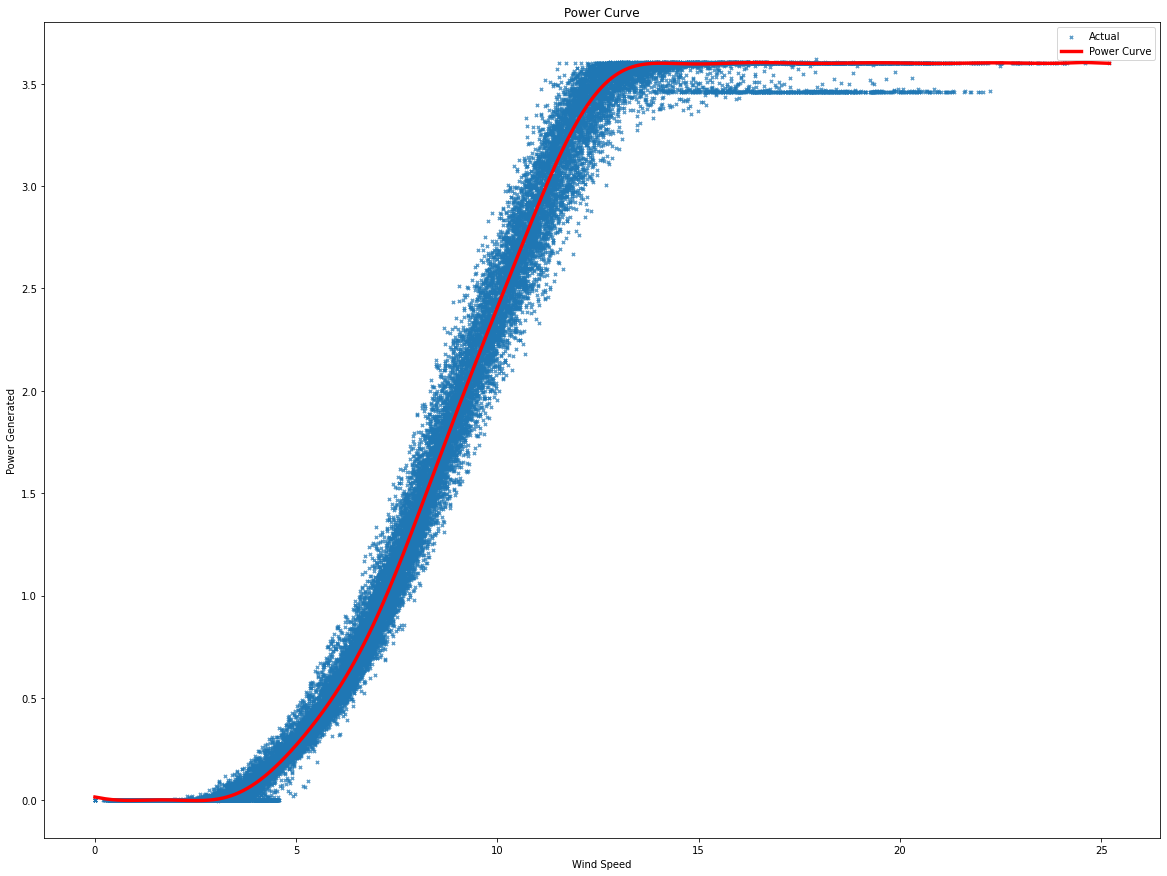

In [171]:
# Prepare and inverse scale data
d = {'X':X.reshape(X.shape[0],),
    'y':y.reshape(y.shape[0],)}
ds = scaler.inverse_transform(pd.DataFrame(d))
ds = pd.DataFrame(ds)
t = {'X':X.reshape(X.shape[0],),
    'tp':tpredictions.reshape(tpredictions.shape[0],)}
ts = scaler.inverse_transform(pd.DataFrame(t))
ts = pd.DataFrame(ts)
# Plot results
plt.figure(figsize=(20,15))
plt.scatter(ds[0],ds[1],alpha=0.7,marker='x',label='Actual',s=10.3)
plt.plot(ts[0],ts[1],c='red',label='Power Curve',lw=3.4)
plt.title('Power Curve')
plt.xlabel('Wind Speed')
plt.ylabel('Power Generated')
plt.legend()
plt.show()

In [190]:
X = train[['Wind Speed (m/s)','LV ActivePower (MW)']]
Xb = pd.DataFrame(scaler.transform(X))
pred = SVM.predict(Xb[0].values.reshape(-1,1))
ds = {'Xb':Xb[0],
     'pred':pred.reshape(pred.shape[0],)}
Xb = pd.DataFrame(scaler.inverse_transform(pd.DataFrame(ds)))
X['pred'] = Xb[1]
X['Error'] = X['LV ActivePower (MW)']-X['pred']

C:\Users\04wil\anaconda3\envs\dsfs\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
<ipython-input-190-5b0b724eec98>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['pred'] = Xb[1]
<ipython-input-190-5b0b724eec98>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Error'] = X['LV ActivePower (MW)']-X['pred']


In [225]:
X2 = X
X2['Error_class'] = np.where(X2['Error']<X2['Error'].describe()['25%']-0.2,1,0)
X2

,Wind Speed (m/s),LV ActivePower (MW),pred,Error,Error_class
0,5.311336,0.380048,0.342546,0.037502,0
1,5.672167,0.453769,0.435619,0.018151,0
2,5.216037,0.306377,0.319502,-0.013125,0
3,5.659674,0.419646,0.432230,-0.012584,0
4,5.577941,0.380651,0.410371,-0.029720,0
...,...,...,...,...,...
37830,11.109290,3.089860,2.953018,0.136842,0
37831,10.038620,2.681419,2.427580,0.253839,0
37832,11.074430,3.083654,2.936599,0.147055,0
37833,11.671360,3.451611,3.199773,0.251838,0


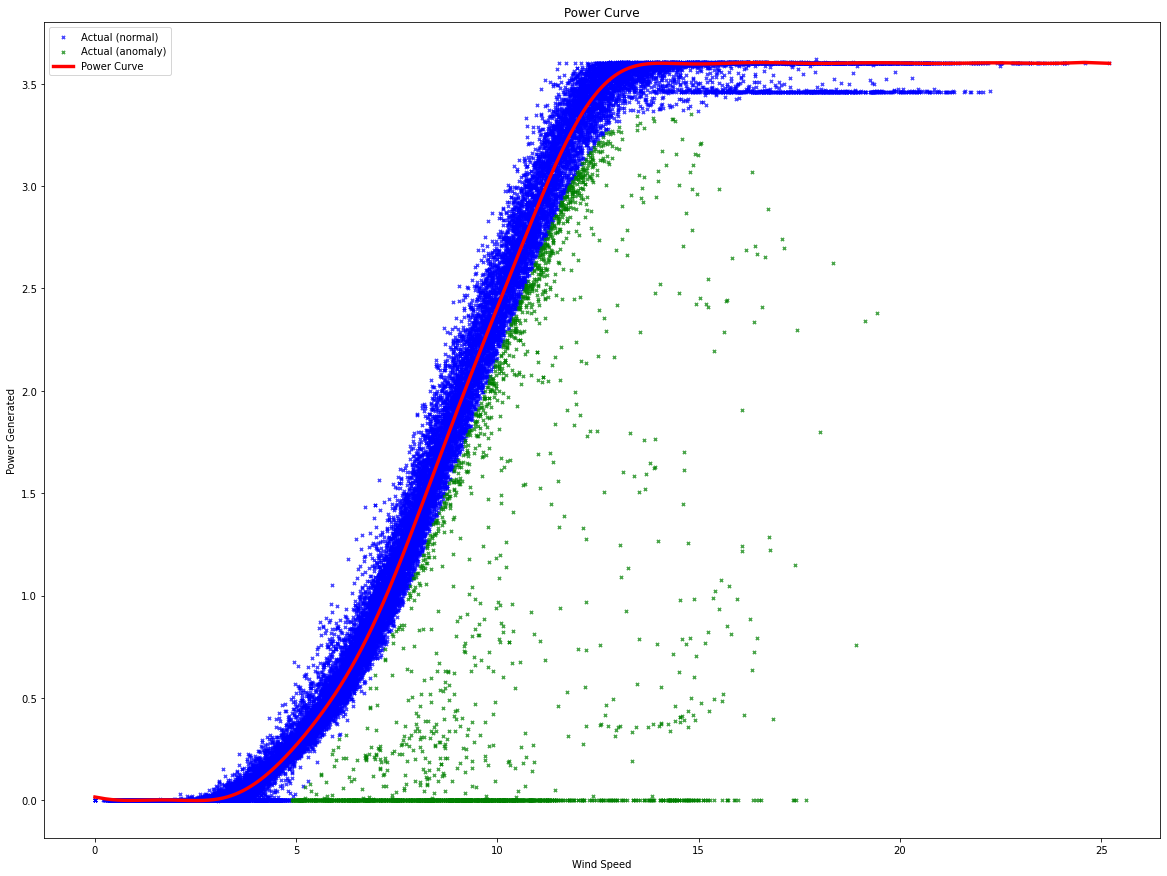

In [226]:
X2 = X2.sort_values(by=['Wind Speed (m/s)'])
Xanom = X2[X2['Error_class']==1]
Xnorm = X2[X2['Error_class']==0]
# Plot results
plt.figure(figsize=(20,15))
plt.scatter(Xnorm['Wind Speed (m/s)'],Xnorm['LV ActivePower (MW)'],alpha=0.7,
            marker='x',c='b',label='Actual (normal)',s=10.3)
plt.scatter(Xanom['Wind Speed (m/s)'],Xanom['LV ActivePower (MW)'],alpha=0.7,
            marker='x',c='green',label='Actual (anomaly)',s=10.3)
plt.plot(X2['Wind Speed (m/s)'],X2['pred'],c='red',label='Power Curve',lw=3.4)
plt.title('Power Curve')
plt.xlabel('Wind Speed')
plt.ylabel('Power Generated')
plt.legend()
plt.show()

In [262]:
testb = test[['Wind Speed (m/s)','LV ActivePower (MW)']]
testb = testb.sort_values(by=['Wind Speed (m/s)']).reset_index(drop=True)
test_X = testb
test_X = pd.DataFrame(scaler.transform(test_X))
pred = SVM.predict(test_X[0].values.reshape(-1,1))
ds = {'Xb':test_X[0],
     'pred':pred.reshape(pred.shape[0],)}
test_X = pd.DataFrame(scaler.inverse_transform(pd.DataFrame(ds)))
test_X[0] = testb['Wind Speed (m/s)']
testb['pred'] = test_X[1]
testb['Error'] = testb['LV ActivePower (MW)']-testb['pred']

In [263]:
testb2 = testb
testb2['Error_class'] = np.where((testb2['Wind Speed (m/s)']>0)&
                                 (testb2['Error']<testb2['Error'].describe()['25%']-0.2),1,0)
testb2[testb2['Error_class']==1]

,Wind Speed (m/s),LV ActivePower (MW),pred,Error,Error_class
2240,4.824163,0.000000,0.231099,-0.231099,1
2244,4.837352,0.000000,0.233904,-0.233904,1
2245,4.838181,0.000000,0.234081,-0.234081,1
2246,4.840941,0.000000,0.234669,-0.234669,1
2253,4.862188,0.000000,0.239220,-0.239220,1
...,...,...,...,...,...
7379,13.948540,2.378393,3.600100,-1.221707,1
7422,14.178240,2.457012,3.600197,-1.143185,1
7537,14.663320,1.283034,3.597545,-2.314510,1
7650,15.231810,3.266669,3.597252,-0.330583,1


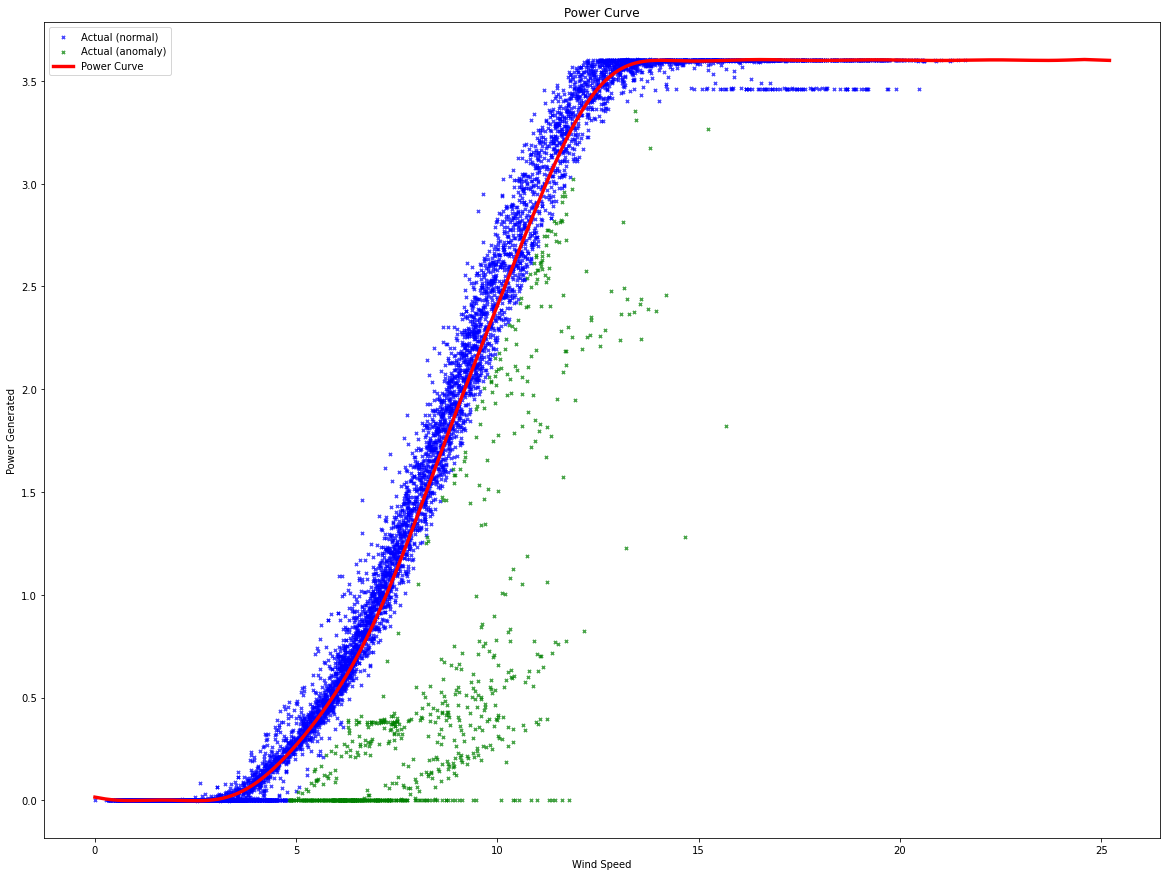

In [266]:
testb2 = testb2.sort_values(by=['Wind Speed (m/s)'],ascending = True)
testb2Xanom = testb2[testb2['Error_class']==1]
testb2Xnorm = testb2[testb2['Error_class']==0]
# Plot results
plt.figure(figsize=(20,15))
plt.scatter(testb2Xnorm['Wind Speed (m/s)'],testb2Xnorm['LV ActivePower (MW)'],alpha=0.7,
            marker='x',c='b',label='Actual (normal)',s=10.3)
plt.scatter(testb2Xanom['Wind Speed (m/s)'],testb2Xanom['LV ActivePower (MW)'],alpha=0.7,
            marker='x',c='green',label='Actual (anomaly)',s=10.3)
plt.plot(X2['Wind Speed (m/s)'],X2['pred'],c='red',label='Power Curve',lw=3.4)
plt.title('Power Curve')
plt.xlabel('Wind Speed')
plt.ylabel('Power Generated')
plt.legend()
plt.show()